In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.stats import truncnorm
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
from IPython.display import display, Math, Latex
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import random
import warnings
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency,chi2
from scipy.stats.distributions import chi2
import scipy, scipy.stats
warnings.filterwarnings("ignore")
%matplotlib inline
import pylab 
import statsmodels.formula.api as smf

### Fencing for outliers

In [2]:
df = pd.read_csv('EDA_human_temperature/data/human_body_temperature.csv')

In [3]:
df['temperature2']=df['temperature']+.2
df.head()

,temperature,gender,heart_rate,temperature2
0,99.3,F,68.0,99.5
1,98.4,F,81.0,98.6
2,97.8,M,73.0,98.0
3,99.2,F,66.0,99.4
4,98.0,F,73.0,98.2


In [4]:
def fence_outliers(df,column,quartile=False):
    observed_column=df[column]
    observed_column_std=df[column].std()
    observed_column_mean=df[column].mean()
    if quartile==True:
        print('Quartile Outliers')
        quartile_1=np.percentile(observed_column, 25)
        quartile_3=np.percentile(observed_column, 75)
        inter_quartile_range=quartile_3-quartile_1
        Inner_fence=1.5*(inter_quartile_range)
        Outer_fence=3*inter_quartile_range
        #Fences for viewing outliers
        #mild outliers
        inner_lower_fence=quartile_1-Inner_fence
        inner_upper_fence=quartile_3+Inner_fence
        #strong outliers
        outer_lower_fence=quartile_1-Outer_fence
        outer_upper_fence=quartile_3+Outer_fence
    else:
        print('Standard Deviation Outliers')
        Inner_fence=3*observed_column_std
        Outer_fence=4*observed_column_std
        #Fences for viewing outliers
        #mild outliers
        inner_lower_fence=observed_column_mean-Inner_fence
        inner_upper_fence=observed_column_mean+Inner_fence
        #strong outliers
        outer_lower_fence=observed_column_mean-Outer_fence
        outer_upper_fence=observed_column_mean+Outer_fence
    return outer_lower_fence,inner_lower_fence,inner_upper_fence,outer_upper_fence

In [5]:
outer_lower_fence,inner_lower_fence,inner_upper_fence,outer_upper_fence=fence_outliers(df,'temperature',quartile=False)

Standard Deviation Outliers


In [6]:
print('Mild Outliers:')
print('Median:',df.temperature.median())
print('Inner Fence:',inner_lower_fence,'&',inner_upper_fence)
comparison=(df['temperature']<inner_lower_fence) | (df['temperature']>inner_upper_fence)
df[comparison]

Mild Outliers:
Median: 98.3
Inner Fence: 96.04968129511394 & 100.44878024334761


,temperature,gender,heart_rate,temperature2
116,100.8,F,77.0,101.0


### Test Normality

In [7]:
def test_normality(df,column):
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    norm=stats.normaltest(df[column])
    print('test statistic: ',norm[0])
    if(norm[1] < 0.05):
        print("P-value: ",norm[1],"\nRejected: differs from a normal distribution.")
    else:
        print("P-value: ",norm[1],"\nNot Rejected: does not differ from a normal distribution.")

In [8]:
test_normality(df,'temperature')

test statistic:  2.703801433319203
P-value:  0.2587479863488254 
Not Rejected: does not differ from a normal distribution.


### One Sample Z-test (Means)

In [9]:
Math(r'H_{0} : \mu_{w} - \bar x_{s} = 0 \\ H_{1} : \mu_{w} - \bar x_{s} \geq 0 ')

<IPython.core.display.Math object>

In [10]:
Math(r'z: = \dfrac{(x_i - \mu_0)}{{s_i}}')

<IPython.core.display.Math object>

In [11]:
def one_sample_z_test(df,column,test_value):
    '''
    Test a difference between observed and expected.
    https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html
    '''
    zscore=ztest(df[column],value=test_value)
    print('z-statistic:', zscore[0],' \n p-value:', zscore[1])
    if zscore[1]<.05:
        print('Our sample mean:',(df[column].mean()))
        print("Conclusion: We reject the null hypothesis.")
    else:
        print("Conclusion: We fail reject the null hypothesis.")   
        return

In [12]:
one_sample_z_test(df,'temperature',98.6)

z-statistic: -5.4548232923645195  
 p-value: 4.9021570141012155e-08
Our sample mean: 98.24923076923078
Conclusion: We reject the null hypothesis.


### Two Sample Z-test (Means)

In [13]:
def two_sample_z_test(df,column1,column2):
    '''
    Test a difference between observed and expected.
    https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html
    '''
    zscore=ztest(df[column1],df[column2],alternative='two-sided')
    print('z-statistic:', zscore[0],' \n p-value:', zscore[1])
    if zscore[1]<.05:
        print('Our sample mean 1:',(df[column1].mean()))
        print('Our sample mean 2:',(df[column2].mean()))
        print("Conclusion: We reject the null hypothesis.")
    else:
        print("Conclusion: We fail reject the null hypothesis.")   
        return

In [14]:
two_sample_z_test(df,'temperature','temperature2')

z-statistic: -2.199247939590984  
 p-value: 0.027860297261270997
Our sample mean 1: 98.24923076923078
Our sample mean 2: 98.4492307692308
Conclusion: We reject the null hypothesis.


### Two Sample Z-test for Proportions

In [15]:
Math(r'z: = \dfrac{(p_1 - p_2)}{\sqrt{\dfrac{p_1*(1-p_1)}{n_1} + \dfrac{p_2*(1-p_2)}{n_2} }}')

<IPython.core.display.Math object>

In [16]:
data = pd.io.stata.read_stata('EDA_racial_discrimination/data/us_job_market_discrimination.dta')

In [17]:
w,b=data.race.value_counts()
calls_nw,calls_w=data.call[data.race=='w'].value_counts()
calls_nb,calls_b=data.call[data.race=='b'].value_counts()
c1,n1,c2,n2=calls_b,w,calls_w,b
p1=c1/n1
p2=c2/n2
count =(c1,c2)
nobs =(n1,n2)

In [18]:
from statsmodels.stats.proportion import proportions_ztest

def two_sample_z_test_proportions(count, nobs):
    zstat, pval = proportions_ztest(count, nobs, value=0, alternative='two-sided')
    print('Estimate:',zstat,'\np-value:',pval)


In [19]:
def two_proportions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its confidence interval;
    resulting confidence interval matches R's prop.test function
    https://stackoverflow.com/questions/47570903/confidence-interval-for-the-difference-between-two-proportions-in-python?rq=1
   
   Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group

    size_a, size_b : int
        Size, or number of observations in each group

    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95

    Returns
    -------
    prop_diff : float
        Difference between the two proportion

    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)

    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [20]:
two_sample_z_test_proportions(count, nobs)

Estimate: -4.108412152434346 
p-value: 3.983886837585077e-05


In [21]:
two_proportions_confint(c1,n1,c2,n2, significance = 0.05)

(0.032032854209445585, array([0.01677773, 0.04728798]))

### One Sample T-test (Means)

In [22]:
Math(r't: = \dfrac{(x_i - \mu_0)}{ \dfrac{s_i}{ \sqrt{n}}}')

<IPython.core.display.Math object>

In [23]:
data1 = np.random.normal(0, 1, size=50)
data2 = np.random.normal(2, 1, size=50)
true_mu = 0

def one_sample_t_test(sample_mean,pop_mean):
    '''
    Test if the sample mean is different than the population mean.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
    '''
    stat,pvalue = stats.ttest_1samp(sample_mean,pop_mean)
    print('t-statistic:', stat,' \n p-value:', pvalue)
    if pvalue<.05:
        print('Our sample mean:',sample_mean.mean())
        print("Conclusion: We reject the null hypothesis.")
    else:
        print("Conclusion: We fail to reject the null hypothesis.")


In [24]:
#sample_mean = df['temperature'].sample(100)

In [25]:
one_sample_t_test(data1,true_mu)

t-statistic: -0.47624064247362297  
 p-value: 0.6360196912689984
Conclusion: We fail to reject the null hypothesis.


### Two Sample T-test (Means)

In [26]:
from scipy.stats import ttest_ind

def two_sample_t_test(column1,column2):
    '''
    We can use this test, if we observe two independent samples from the
    same or different population, e.g. exam scores of boys and girls or of 
    two ethnic groups. The test measures whether the average (expected) 
    value differs significantly across samples. 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    '''
    stat,pval=ttest_ind(column1,column2)
    print('t-statistic:', stat,' \n p-value:', pval)
    if pval<.05:
        print('Our sample mean 1:',(column1.mean()))
        print('Our sample mean 2:',(column2.mean()))
        print("Conclusion: We reject the null hypothesis.")
    else:
        print("Conclusion: We fail reject the null hypothesis.")   
        return

In [27]:
two_sample_t_test(df.temperature[df['gender']=='F'],df.temperature[df['gender']=='M'])

t-statistic: 2.2854345381656103  
 p-value: 0.02393188312239561
Our sample mean 1: 98.39384615384613
Our sample mean 2: 98.1046153846154
Conclusion: We reject the null hypothesis.


$$H_0 : \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5$$

$$H_1 : \mu_i \ne \mu_j$$

$$F = \frac{MS_{b}} {MS_w}$$

$$MS_{b} = \frac{SS_{b}} {K-1}$$

$$MS_{w} = \frac{SS_{w}} {N-K}$$

$$SS_{b} = {n_k\sum(\bar{x_{k}}-\bar{x_{G}})^2}$$

$$SS_{w} = \sum(x_{i}-\bar{x_{k}})^2$$

### Anova

In [28]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735,0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835,0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

In [35]:
def three_way_anova(variable1,variable2,variable3):
    variable_list=[variable1,variable2,variable3]
    '''
    The one-way ANOVA tests the null hypothesis that two or 
    more groups have the same population mean. 
    The test is applied to samples from two or more groups,
    possibly with differing sizes.
    The ANOVA test has important assumptions 
    that must be satisfied in order for the associated p-value to be valid.
        The samples are independent.
        Each sample is from a normally distributed population.
        The population standard deviations of the groups are all equal. 
        This property is known as homoscedasticity.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
    '''
    stat,pvalue=stats.f_oneway(variable1,variable2,variable3)
    print('F-statistic:', stat,' \n p-value:', pvalue)
    if pvalue<.05:
        [print('Sample Mean:',np.mean(x)) for x in variable_list]
        print("Conclusion: We reject the null hypothesis.")
    else:
        print("Conclusion: We fail reject the null hypothesis.")   
        return

In [36]:
three_way_anova(tillamook,newport,petersburg)

F-statistic: 11.200832489917023  
 p-value: 0.00044183251892694495
Sample Mean: 0.0802
Sample Mean: 0.07479999999999999
Sample Mean: 0.10344285714285714
Conclusion: We reject the null hypothesis.


### 2x2 Chi-Square Contingency Table

In [37]:
Math(r'X^2: = \dfrac{(O - E)^2}{E}')

<IPython.core.display.Math object>

*creating a contingency table*

In [38]:
#Frequency table
data_race_call=data[['call','race']]
data_race_call.head()

,call,race
0,0.0,w
1,0.0,w
2,0.0,b
3,0.0,b
4,0.0,w


In [39]:
exposure=data_race_call.call
treatment=data_race_call.race

In [40]:
def chi_contingency_table(treatment,exposure):
    '''
    Treatment: 
    - Those whom were assigned a treatment and those not (case/control).
    Exposure: 
    - The disease in question,  'exposed/unexposed'
    '''
    cross_tab=pd.crosstab(exposure,treatment,margins=True)
    return cross_tab

In [41]:
chi_contingency_table=chi_contingency_table(treatment,exposure)
chi_contingency_table=chi_contingency_table.reindex([1, 0, "All"])
chi_contingency_table.index=['Exposed','Unexposed','Total']
chi_contingency_table.columns=['Case','Control','Total']

*This is the format I like to see, but I've seen it displayed in different orientations*

In [42]:
chi_contingency_table

,Case,Control,Total
Exposed,157,235,392
Unexposed,2278,2200,4478
Total,2435,2435,4870


In [43]:
#Probability table
chi_contingency_table_prob=chi_contingency_table/4870
chi_contingency_table_freq=chi_contingency_table.T
display(chi_contingency_table_freq) 
display(chi_contingency_table_prob)

,Exposed,Unexposed,Total
Case,157,2278,2435
Control,235,2200,2435
Total,392,4478,4870


,Case,Control,Total
Exposed,0.032238,0.048255,0.080493
Unexposed,0.467762,0.451745,0.919507
Total,0.500000,0.500000,1.000000


In [44]:
def chi_square_stats(chi_contingency_table_freq):
    '''
    Takes in a table in the format above and returns:
    - Odds Ratio
    - Risk Ratio (Relative Risk)
    - Phi Coefficient
    - Likely-hood Ratio
    - ChiSquare pval
    '''
    chiSquareTemp=chi_contingency_table_freq
    #observed
    a,b,c,d=chiSquareTemp.iloc[1,1],chiSquareTemp.iloc[1,0],\
    chiSquareTemp.iloc[0,1],chiSquareTemp.iloc[0,0]
    #Totals
    col1Sum=np.sum(a+c)
    col2Sum=np.sum(b+d)
    row1Sum=np.sum(a+b)
    row2Sum=np.sum(c+d)
    totalSum=np.sum(col1Sum+col2Sum)
       #row total               column total
    e=(col1Sum*row1Sum)/totalSum #a expected
    f=(col2Sum*row1Sum)/totalSum #b expected

    g=(col1Sum*row2Sum)/totalSum #c expected
    h=(col2Sum*row2Sum)/totalSum #d expected
    #Modify table labels
    obs=pd.DataFrame([[a,b],[c,d]])

    #Get Chi2 and LR for table
    chi2, pvalue1, dof1, expected1 = chi2_contingency(obs,correction=True)
    LR, pvalue2, dof2, expected2 = chi2_contingency(obs, lambda_="log-likelihood")
    #calculated phi for table
    phi=(a*d-b*c)/np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    phiTable=list([phi,'',''])
    estimates=pd.DataFrame([[chi2,dof1,pvalue1],[LR,dof2,pvalue2],phiTable],columns=['Value','DF','Prob'])
    #Rename Indexes 
    estimates.rename(index={0: 'Chi-Square',1: 'Likelihood Ratio Chi2',2:'Phi Coefficient'},inplace=True)


    table = np.asarray(obs)
    results = sm.stats.Table2x2(table.T)
    print(results.summary())
    return estimates

In [45]:
chi_square_stats(chi_contingency_table_freq)

               Estimate   SE   LCB    UCB   p-value
---------------------------------------------------
Odds ratio        0.645        0.523  0.796   0.000
Log odds ratio   -0.438 0.107 -0.649 -0.228   0.000
Risk ratio        0.820        0.752  0.893   0.000
Log risk ratio   -0.199 0.044 -0.285 -0.113   0.000
---------------------------------------------------


,Value,DF,Prob
Chi-Square,16.449029,1,4.99758e-05
Likelihood Ratio Chi2,16.547891,1,4.74367e-05
Phi Coefficient,-0.058872,,


### Linear Regression

$$Y = \beta_0 + \beta_1 X + \epsilon$$

$$\hat\beta =  (X^T X)^{-1}X^T Y$$

In [60]:
from sklearn.datasets import load_boston
boston = load_boston()
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target

In [72]:
from sklearn.linear_model import LinearRegression 
from sklearn import feature_selection

def linear_regression(X, y):
    '''
    Regression Function for this project.
    '''
    X_reshape=X.values.reshape(-1,1)
    reg = LinearRegression().fit(X_reshape, y)
    intercept = reg.intercept_
    coef = reg.coef_
    predict=reg.predict(X_reshape)
    r2 = reg.score(X_reshape, y)
    fstat,pvalue=sklearn.feature_selection.f_regression(X_reshape, y)
    fstat[0],r2,pvalue[0],intercept,coef,predict
    try:
        sns.jointplot(X, y, kind="reg")
    except:
        print("Can't Plot.")
    return 

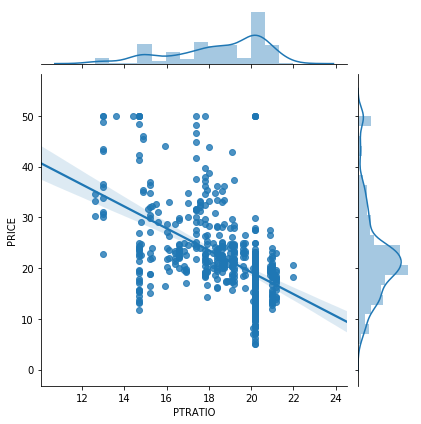

In [74]:
linear_regression(bos.PTRATIO, bos.PRICE)

### Logistic Regression

In [76]:
data = pd.io.stata.read_stata('EDA_racial_discrimination/data/us_job_market_discrimination.dta')

In [138]:
x_cols=['education','honors','volunteer','military','empholes','compreq','orgreq','manuf','transcom','bankreal','trade','busservice','othservice']

In [139]:
data[x_cols].head()

,education,honors,volunteer,military,empholes,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice
0,4,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3,0,1,1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [140]:
data[x_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 13 columns):
education     4870 non-null int8
honors        4870 non-null int8
volunteer     4870 non-null int8
military      4870 non-null int8
empholes      4870 non-null int8
compreq       4870 non-null float32
orgreq        4870 non-null float32
manuf         4870 non-null float32
transcom      4870 non-null float32
bankreal      4870 non-null float32
trade         4870 non-null float32
busservice    4870 non-null float32
othservice    4870 non-null float32
dtypes: float32(8), int8(5)
memory usage: 214.0 KB


In [143]:
def logistic_regression(df,x_cols,y_col):
    y=df[y_col].values
    X=df[x_cols].copy()
    X['intercept']=1
    X=X.values
    est = sm.Logit(y, X)
    result = est.fit()
    print(result.summary())
    return result

In [144]:
results=logistic_regression(data,x_cols,y_col)

Optimization terminated successfully.
         Current function value: 0.272562
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4856
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Sep 2019   Pseudo R-squ.:                 0.02646
Time:                        00:33:21   Log-Likelihood:                -1327.4
converged:                       True   LL-Null:                       -1363.5
                                        LLR p-value:                 3.196e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0015      0.075     -0.020      0.984      -0.148       0.145
x2             0.7443      0.

### Complex Odds Ratio

In [149]:
#b0+b1+b2/b0+b1+b2+b3
np.exp(-2.6436+-0.0015+0.7443)/np.exp(-2.6436+-0.0015+0.7443+0.1648)

0.8480632997877381